# This notebook makes a TF-IDF analysis on a graph G consisting of lyrics

In [ ]:
import networkx as nx
import re
import os
import json
from pathlib import Path
from nltk.stem import WordNetLemmatizer
from collections import Counter
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In the following we create TF lists and IDF word counts of the tokens/words of the artists lyrics. 

- We have filtered out words that appear less than 5 times, and all punctuation. 
- We have also made all characters lower case. 
- We also remove some stop words
- We generate TF lists for the top 5 represented genres.
- We normalize TF by the total tokens per artist.

In [15]:
# Import the graph
G = nx.read_graphml("tmp/artist_network.graphml")

# Compute TF-IDF for each artist
def compute_idf(df, N, method="smooth"):
    if method == "standard":
        return math.log10(N / df)
    elif method == "smooth":
        return math.log10(N / (1 + df)) + 1
    elif method == "prob":
        return math.log10((N - df) / df)

In [ ]:
# Creating TF-IDF analysis

lemmatizer = WordNetLemmatizer()
stopwords = set(ENGLISH_STOP_WORDS)

# remove sound words like 'oh', 'la', 'na', 'yeah', 'ooh'
sound_words = {'oh', 'la', 'na', 'yeah', 'ooh', 'uh', 'ta', 'ah', 'hoo', 'ha', 'mm', 
               'hmm', 'da', 'wo', 'woah', 'whoa', 'hey', 'ay', 'ayyy', 'woo', 'woohoo',
               'ra-ta-ta-ta-ta-ta-ta-ta-ta-ta', 'dum', 'dum-dum', 'la-la-la', 'na-na-na', 'laa', 'laaa',
               'naaa', 'naaaa', 'yeaaah', 'yeaah', 'yeaaaah', 'ooh-ooh', 'uh-huh', 'mm-hmm',
               'ba-bum-bum-bum-bum', 'bom', 'bom-bom', 'da-da-da', 'da-da', 'duh', 'duh-duh', 'la-la',
               'na-na', 'na-na-na-na', 'whoa-oh', 'whoa-oh-oh', 'woo-woo', 'woo-woo-woo', 'yah', 'yahh',
               'ba-bum-bum-bum-bum', 'ba-bum-bum-bum-bum-bum', 'oh-oh', 'oh-oh-oh', 'uh-oh', 'uh-oh-oh','ooh-ooh-ooh',
               'woo-hoo','m-m-m-m-m', 'oh-nah-nah-nah','mmm-mm-hmm-mm', 'mm-mm-hmm', 'hmmm-mm'}
uninteresting_words = {"i'm", "im", "ive", "i've", "youre", "you're", "hes", "he's", "it's", "its",
                       "shes", "she's", "thats", "that's", "whats", "what's", "couldnt", "i'll", "ill", "youll", "you'll",
                       "he'll", "she'll", "we'll", "well", "they'll", "theyll", "isnt", "isn't", "wasnt", "wasn't",
                       "werent", "weren't", "dont", "don't", "doesnt", "doesn't", "wont", "won't",
                       "couldn't", "wouldnt", "wouldn't", "didnt", "didn't", "got", "gonna","there's"}
stopwords.update(sound_words)
stopwords.update(uninteresting_words)

TF_lists = {}           # Term frequencies per artist
IDF_counts = {}         # Document frequency per word
num_docs = len(G.nodes)

# Build TF and IDF counts
for node in G.nodes(data=True):
    artist = node[0]
    lyrics = node[1].get('lyrics', '')

    # Tokenize and lemmatize
    lyrics = lyrics.replace("’", "'")
    tokens = re.findall(r"\b[\w'-]+\b", lyrics.lower())
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords]

    word_counts = Counter(lemmatized_tokens)
    TF_lists[artist] = word_counts

    # Update IDF counts
    for word in word_counts.keys():
        IDF_counts[word] = IDF_counts.get(word, 0) + 1
    
TFIDF_scores = {}
for artist, word_counts in TF_lists.items():
    total_terms = sum(word_counts.values())
    tfidf = {}
    for word, count in word_counts.items():
        tf = count / total_terms
        idf = compute_idf(IDF_counts[word], num_docs, method="smooth")
        tfidf[word] = tf * idf
    TFIDF_scores[artist] = tfidf


In [46]:
# inspect IDF_counts
sorted_df = sorted(IDF_counts.items(), key=lambda x: x[1], reverse=True)
print("Top by document frequency:", sorted_df[:100])
print("Words appearing in only one doc:", [w for w,c in sorted_df if c==1][:100])

Top by document frequency: [('like', 3552), ('know', 2517), ("don't", 2460), ('just', 2399), ('love', 2093), ('time', 2073), ('make', 1931), ('come', 1928), ('say', 1858), ('way', 1784), ('cause', 1782), ("can't", 1758), ('let', 1757), ('want', 1724), ('feel', 1653), ('right', 1636), ("i'll", 1573), ('day', 1560), ('need', 1553), ('night', 1543), ('life', 1540), ('thing', 1514), ('baby', 1511), ('tell', 1505), ('heart', 1426), ('think', 1420), ('good', 1405), ('girl', 1386), ('man', 1360), ('eye', 1344), ('wanna', 1339), ('away', 1323), ('look', 1313), ("ain't", 1307), ('said', 1264), ('little', 1241), ('mind', 1235), ("won't", 1228), ('hand', 1225), ('light', 1214), ('world', 1176), ('low', 1171), ("there's", 1157), ('long', 1148), ('home', 1140), ('better', 1132), ('hold', 1132), ('head', 1128), ('new', 1112), ('stay', 1062), ('turn', 1058), ('stop', 1056), ('friend', 1049), ('face', 1043), ('boy', 1038), ('real', 1022), ("we're", 1014), ('leave', 1006), ('hear', 1003), ('really', 10

We can now visualize the difference between the TF and TF-IDF in wordclouds. We have chosen to display the top 50 words to make it possible to distinguish between the words but still get a large representation. 

In [44]:
# create wordcloud for each genre with both TF and TF-IDF top 50 words
from wordcloud import WordCloud
from collections import Counter

def generate_wordcloud(word_freq, num_words=30, title='WordCloud'):
    wordcloud = WordCloud(width=800, height=400, max_words=num_words, background_color='white').generate_from_frequencies(word_freq)
    return wordcloud

# plot subplots of 5 different wordclouds for the 5 artist with highest degree; both TF and TF-IDF
sample_artists = sorted(G.degree, key=lambda x: x[1], reverse=True)[:5]
sample_artists = [artist for artist, degree in sample_artists]


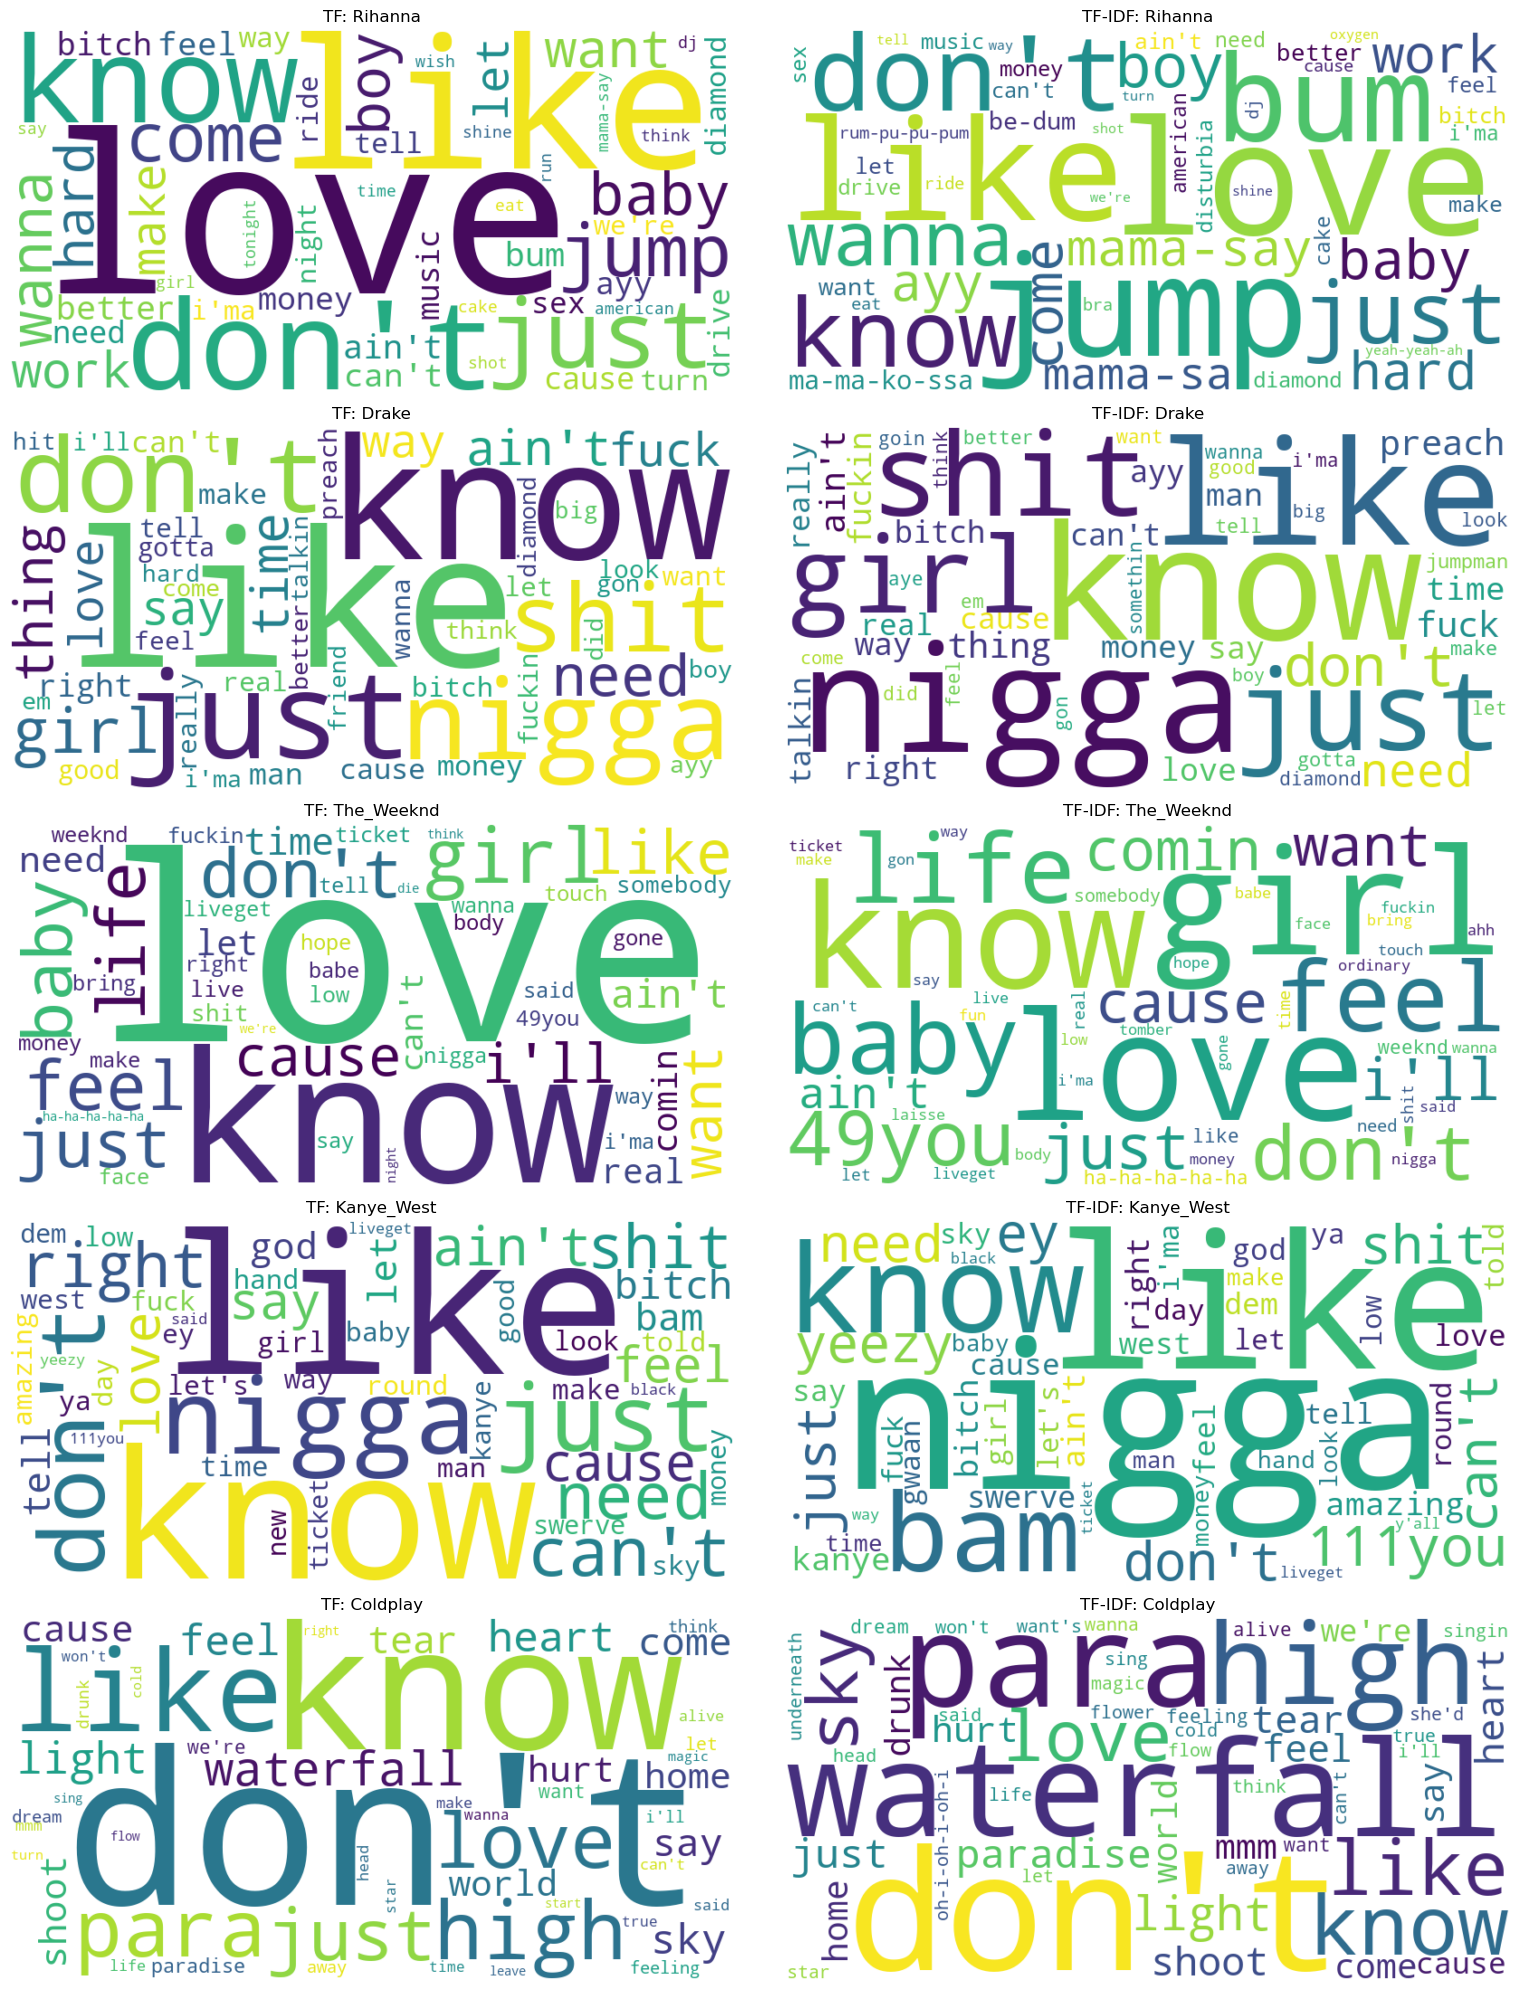

In [45]:

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))
axes = axes.flatten()

for i, artist in enumerate(sample_artists):
    # TF (top 50 by raw count, normalized)
    tf_counts = TF_lists.get(artist, Counter())
    total = sum(tf_counts.values()) or 1
    tf_freq = {w: c / total for w, c in tf_counts.most_common(50)}
    wc_tf = generate_wordcloud(tf_freq, num_words=50)
    ax_tf = axes[2 * i]
    ax_tf.imshow(wc_tf, interpolation='bilinear')
    ax_tf.axis('off')
    ax_tf.set_title(f'TF: {artist}')

    # TF-IDF (top 50 by score)
    tfidf_freq = TFIDF_scores.get(artist, {})
    tfidf_top = dict(sorted(tfidf_freq.items(), key=lambda x: x[1], reverse=True)[:50])
    wc_tfidf = generate_wordcloud(tfidf_top, num_words=50)
    ax_tfidf = axes[2 * i + 1]
    ax_tfidf.imshow(wc_tfidf, interpolation='bilinear')
    ax_tfidf.axis('off')
    ax_tfidf.set_title(f'TF-IDF: {artist}')

plt.tight_layout()
plt.show()